Mareno Demmers   
ZM002-25-1: Artificial intelligence   
pi7 part1   

# Genetic Algorithm

A genetic algorithm starts with an initial population of solutions that evolves using selection, crossover, and mutation operators. These operators can be implemented in different ways, each affecting the performance.[](https://www.geeksforgeeks.org/dsa/genetic-algorithms/)[](https://www.mathworks.com/help/gads/how-the-genetic-algorithm-works.html)[](https://pmc.ncbi.nlm.nih.gov/articles/PMC7274742/)

## Parent Selection Methods
Parent selection determines which solutions breed and pass their qualities to the next generation.[](https://www.tutorialspoint.com/genetic_algorithms/genetic_algorithms_parent_selection.htm)
- **Roulette Wheel Selection**: Probability proportional to fitness; maintains diversity.
- **Tournament Selection**: Selects the best from random subsets; speeds convergence, possibly reduces diversity.
- **Rank Selection**: Sorts individuals by fitness and selects with a bias.
- **Elitism**: Always keeps a few best solutions; improves stability, combats loss of good genes.
- For sequencing, tournament selection is preferred for balancing exploration and exploitation.[](https://algorithmafternoon.com/books/genetic_algorithm/chapter04/)

## Crossover Methods

- **Single-point crossover**: Efficient, often used in GAs, good for simple solution encoding. Produces offspring with contiguous blocks from parents—great for maintaining solution structure.[](https://bdm.ufpa.br/bitstream/prefix/7788/1/TCC_ComparisonCrossoverOperators.pdf)[](https://wseas.com/journals/computers/2013/5705-156.pdf)
- **Multi-point crossover**: Uses multiple cut points; increases diversity and exploration capability but may disrupt good gene combinations.[](https://wseas.com/journals/computers/2013/5705-156.pdf)[](https://bdm.ufpa.br/bitstream/prefix/7788/1/TCC_ComparisonCrossoverOperators.pdf)
- **Uniform crossover**: Swaps genes randomly based on a mask, promoting high diversity but can break useful gene combinations more easily.[](https://bdm.ufpa.br/bitstream/prefix/7788/1/TCC_ComparisonCrossoverOperators.pdf)[](https://wseas.com/journals/computers/2013/5705-156.pdf)
- **Specialized crossovers** (Order Crossover OX, Partially Mapped PMX, Cycle Crossover CX): Designed for sequencing problems and maintain order or position relationships, typically yielding better results for job sequencing tasks.[](https://dergipark.org.tr/en/download/article-file/4353944)[](https://www.atlantis-press.com/article/25845582.pdf)[](https://wseas.com/journals/computers/2013/5705-156.pdf)
	- For job sequencing, Order and PMX crossovers are commonly recommended due to their ability to preserve job order and avoid duplicates.[](https://www.atlantis-press.com/article/25845582.pdf)[](https://dergipark.org.tr/en/download/article-file/4353944)

## Mutation Operators
Mutation introduces random changes to individual solutions to prevent premature convergence and explore new search regions. Typical mutation methods for job sequencing include:[](https://en.wikipedia.org/wiki/Genetic_algorithm)

- **Swap Mutation**: Randomly swaps two jobs in the sequence; maintains feasibility.
- **Insertion Mutation**: Moves a job to a random position; helps maintain legal sequences.
- Mutation rate must be balanced: too low may cause genetic drift, too high can erase good solutions unless elite retention is used.[](https://en.wikipedia.org/wiki/Genetic_algorithm)

In [44]:
import random

## Fitness function

In [45]:
def fitness(schedule, deadlines, profits):
    total_profit = 0
    job_count = 0

    i = 0
    for job in schedule:
        if i < deadlines[job]:
            total_profit += profits[job]
            job_count += 1
        i += 1

    return total_profit, job_count

## Population

In [46]:
def init_pop(n_jobs, pop_size):
    population = []

    for _ in range(pop_size):
        candidate = list(range(n_jobs))
        random.shuffle(candidate)
        population.append(candidate)

    return population

## Selection

In [47]:
def tournament_selection(pop, scores, k=3):
    selected = random.sample(range(len(pop)), k)
    selected.sort(key=lambda i: scores[i], reverse=True)

    return pop[selected[0]]

def roulette_wheel_selection(pop, scores):
    total_fitness = sum(scores)
    
    if total_fitness == 0:
        return random.choice(pop)
    
    pick = random.uniform(0, total_fitness)
    current = 0
    
    for i, individual in enumerate(pop):
        current += scores[i]
        if current > pick:
            return individual
    
    return pop[-1]
    
def rank_selection(pop, scores):
    sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i])
    ranks = [0] * len(scores)
    for i, idx in enumerate(sorted_indices):
        ranks[idx] = i + 1
    
    return roulette_wheel_selection(pop, ranks)

## Crossover

In [48]:
# standard single point does not work here because it can end up making schedules with duplicate and missing jobs
def order_preserving_one_point_crossover(parent1, parent2):
    n = len(parent1)
    cutoff = random.randrange(1, n)
    child = parent1[:cutoff]
    for gene in parent2:
        if gene not in child:
            child.append(gene)
    return child

def order_crossover(parent1, parent2):
    n = len(parent1)
    p1, p2 = sorted(random.sample(range(n), 2))
    child = [-1] * n
    child[p1:p2] = parent1[p1:p2]
    ptr = p2

    for idx in range(n):
        if parent2[idx] not in child:
            if ptr == n: ptr = 0
            child[ptr] = parent2[idx]
            ptr += 1

    return child

def uniform_crossover(parent1, parent2, prob=0.5):
    n = len(parent1)
    child = [-1] * n
    used = set()
    
    for i in range(n):
        if random.random() < prob:
            if parent1[i] not in used:
                child[i] = parent1[i]
                used.add(parent1[i])
        else:
            if parent2[i] not in used:
                child[i] = parent2[i]
                used.add(parent2[i])
    
    missing = [gene for gene in range(n) if gene not in used]
    for i in range(n):
        if child[i] == -1:
            child[i] = missing.pop(0)
    
    return child


def partially_mapped_crossover(parent1, parent2):
    n = len(parent1)
    p1, p2 = sorted(random.sample(range(n), 2))
    
    child = [-1] * n
    child[p1:p2] = parent1[p1:p2]
    
    mapping = {}
    for i in range(p1, p2):
        mapping[parent2[i]] = parent1[i]
    
    for i in range(n):
        if child[i] == -1:
            val = parent2[i]
            visited = set()
            while val in child and val not in visited:
                visited.add(val)
                if val in mapping:
                    val = mapping[val]
                else:
                    for candidate in range(n):
                        if candidate not in child:
                            val = candidate
                            break
                    break
            child[i] = val
    
    return child

def cycle_crossover(parent1, parent2):
    n = len(parent1)
    child = [-1] * n
    visited = [False] * n
    
    for start in range(n):
        if visited[start]:
            continue
            
        current = start
        cycle_positions = []
        
        while not visited[current]:
            visited[current] = True
            cycle_positions.append(current)
            
            value = parent1[current]
            current = parent2.index(value)
        
        use_parent1 = (start % 2 == 0) 
        for pos in cycle_positions:
            child[pos] = parent1[pos] if use_parent1 else parent2[pos]
    
    return child

## Mutation

In [49]:
def swap_mutation(chrom):
    a, b = random.sample(range(len(chrom)), 2)
    chrom[a], chrom[b] = chrom[b], chrom[a]

    return chrom

def insertion_mutation(chrom):
    chrom = chrom[:]
    if len(chrom) < 2:
        return chrom
    
    i = random.randrange(len(chrom))
    j = random.randrange(len(chrom))
    gene = chrom.pop(i)
    chrom.insert(j, gene)
    return chrom

## Full implementation

In [ ]:
def genetic_algorithm_configurable(deadline, profit,
                                   pop_size=50, num_gens=100,
                                   crossover_rate=0.7, mutation_rate=0.1,
                                   selection_method="tournament",
                                   crossover_method="order",
                                   mutation_method="swap",
                                   elitism=0):
    
    selection_funcs = {
        "tournament": tournament_selection,
        "roulette": roulette_wheel_selection,
        "rank": rank_selection
    }
    
    crossover_funcs = {
        "order": order_crossover,
        "pmx": partially_mapped_crossover,
        "cycle": cycle_crossover,
        "uniform": uniform_crossover,
        "single_point": order_preserving_one_point_crossover
    }
    
    mutation_funcs = {
        "swap": swap_mutation,
        "insertion": insertion_mutation
    }
    
    n_jobs = len(deadline)
    population = init_pop(n_jobs, pop_size)
    best_profit = 0
    best_schedule = None
    fitness_history = []  
    
    selection_func = selection_funcs[selection_method]
    crossover_func = crossover_funcs[crossover_method]
    mutation_func = mutation_funcs[mutation_method]

    for gen in range(num_gens):
        scores = [fitness(ind, deadline, profit)[0] for ind in population]
        
        current_best = max(scores) if scores else 0
        fitness_history.append(current_best) 
        
        if current_best > best_profit:
            best_profit = current_best
            best_idx = scores.index(current_best)
            best_schedule = population[best_idx][:]
        
        new_pop = []
        
        if elitism > 0 and scores:
            elite_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:elitism]
            for idx in elite_indices:
                new_pop.append(population[idx][:])
        
        for _ in range(pop_size - elitism):
            parent1 = selection_func(population, scores)
            parent2 = selection_func(population, scores)

            if random.random() < crossover_rate:
                child = crossover_func(parent1, parent2)
            else:
                child = parent1[:]

            if random.random() < mutation_rate:
                child = mutation_func(child)

            new_pop.append(child)

        population = new_pop

    jobs_completed = fitness(best_schedule, deadline, profit)[1]
    return jobs_completed, best_profit, best_schedule, fitness_history

## Usage

In [51]:
deadline = [2, 1, 2, 1, 1]
profit = [100, 19, 27, 25, 15]
# ans = genetic_algorithm(deadline, profit)
# print(ans)

genetic_algorithm_configurable(deadline, profit)

(2,
 127,
 [0, 2, 3, 1, 4],
 [127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127,
  127])

## Evaluation

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

def load_test_data(filepath):
    df = pd.read_excel(filepath, sheet_name='p4', header=0)

    deadlines = df.iloc[:, 1].tolist()
    profits = df.iloc[:,2].tolist()

    return {
        'deadline': deadlines,
        'profit': profits
    }

test_data = load_test_data('example_problems.xlsx')

# Test datasets
test_cases = {
    'test1' : test_data
}

def run_full_factorial_study():
    selections = ["tournament", "roulette", "rank"]
    crossovers = ["order", "pmx", "uniform", "cycle", "single_point"]
    mutations = ["swap", "insertion"] 
    elitisms = [0, 1, 3]
    
    configs = []
    for sel in selections:
        for cross in crossovers:
            for mut in mutations:
                for elit in elitisms:
                    configs.append({
                        "selection": sel,
                        "crossover": cross, 
                        "mutation": mut,
                        "elitism": elit
                    })
    
    print(f"Total configurations to test: {len(configs)}")
    
    results = []
    convergence_data = {}
    
    for test_name, test_data in test_cases.items():
        print(f"\nTesting {test_name} dataset...")
        
        for i, config in enumerate(configs):
            print(f"  Progress: {i + 1}/{len(configs)}")

            config_name = f"{config['selection'][:4]}-{config['crossover'][:4]}-{config['mutation'][:4]}-e{config['elitism']}"
            
            #  multiple trials 
            trial_results = []
            trial_times = []
            trial_histories = []
            
            for trial in range(5):  
                start_time = time.time()
                
                jobs, profit_val, schedule, history = genetic_algorithm_configurable(
                    test_data['deadline'], test_data['profit'],
                    selection_method=config['selection'],
                    crossover_method=config['crossover'], 
                    mutation_method=config['mutation'],
                    elitism=config['elitism'],
                    num_gens=50,
                    pop_size=30
                )
                
                end_time = time.time()
                
                trial_results.append(profit_val)
                trial_times.append(end_time - start_time)
                trial_histories.append(history)
            
            # Calculate convergence 
            avg_history = np.mean(trial_histories, axis=0)
            convergence_gen = np.mean([np.argmax(h) for h in trial_histories]) 
            final_improvement = np.mean([(h[-1] - h[0]) / max(h[0], 1) for h in trial_histories])  
            
            results.append({
                'test_case': test_name,
                'config': config_name,
                'selection': config['selection'],
                'crossover': config['crossover'],
                'mutation': config['mutation'],
                'elitism': config['elitism'],
                'avg_profit': np.mean(trial_results),
                'std_profit': np.std(trial_results),
                'max_profit': np.max(trial_results),
                'min_profit': np.min(trial_results),
                'avg_time': np.mean(trial_times),
                'convergence_gen': convergence_gen,
                'final_improvement': final_improvement,
                'early_convergence': np.mean([np.argmax(h) < len(h) * 0.5 for h in trial_histories])  
            })

            
            convergence_data[f"{test_name}-{config_name}"] = avg_history
    
    return pd.DataFrame(results), convergence_data

results_df, convergence_data = run_full_factorial_study()
print("Experiment completed!")

Total configurations to test: 90

Testing test1 dataset...
  Progress: 1/90
  Progress: 2/90
  Progress: 3/90
  Progress: 4/90
  Progress: 5/90
  Progress: 6/90
  Progress: 7/90
  Progress: 8/90
  Progress: 9/90
  Progress: 10/90
  Progress: 11/90
  Progress: 12/90
  Progress: 13/90
  Progress: 14/90
  Progress: 15/90
  Progress: 16/90
  Progress: 17/90
  Progress: 18/90
  Progress: 19/90
  Progress: 20/90
  Progress: 21/90
  Progress: 22/90
  Progress: 23/90
  Progress: 24/90
  Progress: 25/90
  Progress: 26/90
  Progress: 27/90
  Progress: 28/90
  Progress: 29/90
  Progress: 30/90
  Progress: 31/90
  Progress: 32/90
  Progress: 33/90
  Progress: 34/90
  Progress: 35/90
  Progress: 36/90
  Progress: 37/90
  Progress: 38/90
  Progress: 39/90
  Progress: 40/90
  Progress: 41/90
  Progress: 42/90
  Progress: 43/90
  Progress: 44/90
  Progress: 45/90
  Progress: 46/90
  Progress: 47/90
  Progress: 48/90
  Progress: 49/90
  Progress: 50/90
  Progress: 51/90
  Progress: 52/90
  Progress: 53


FULL FACTORIAL DESIGN RESULTS WITH CONVERGENCE ANALYSIS

TOP 10 CONFIGURATIONS:
           config  avg_profit  std_profit  convergence_gen  avg_time
roul-unif-inse-e3       848.4   65.752871             38.8  0.034079
roul-unif-inse-e1       826.0   51.283526             30.2  0.037106
rank-unif-inse-e1       819.2   67.921720             18.2  0.043128
 tour-pmx-swap-e0       811.0   44.240253             18.0  0.844879
tour-unif-inse-e0       800.8   54.105083             20.4  0.037476
 roul-pmx-swap-e3       783.8   45.516590             35.0  1.041246
rank-unif-swap-e0       781.2   26.962196             27.2  0.043725
rank-unif-inse-e0       775.8   30.015996             17.0  0.044048
rank-unif-inse-e3       762.8   28.251726             22.6  0.040310
roul-unif-inse-e0       759.4   51.398833             35.8  0.037521

CONVERGENCE ANALYSIS

Fastest Converging Configurations:
           config  avg_profit  convergence_gen  early_convergence
rank-sing-inse-e0       478.6       

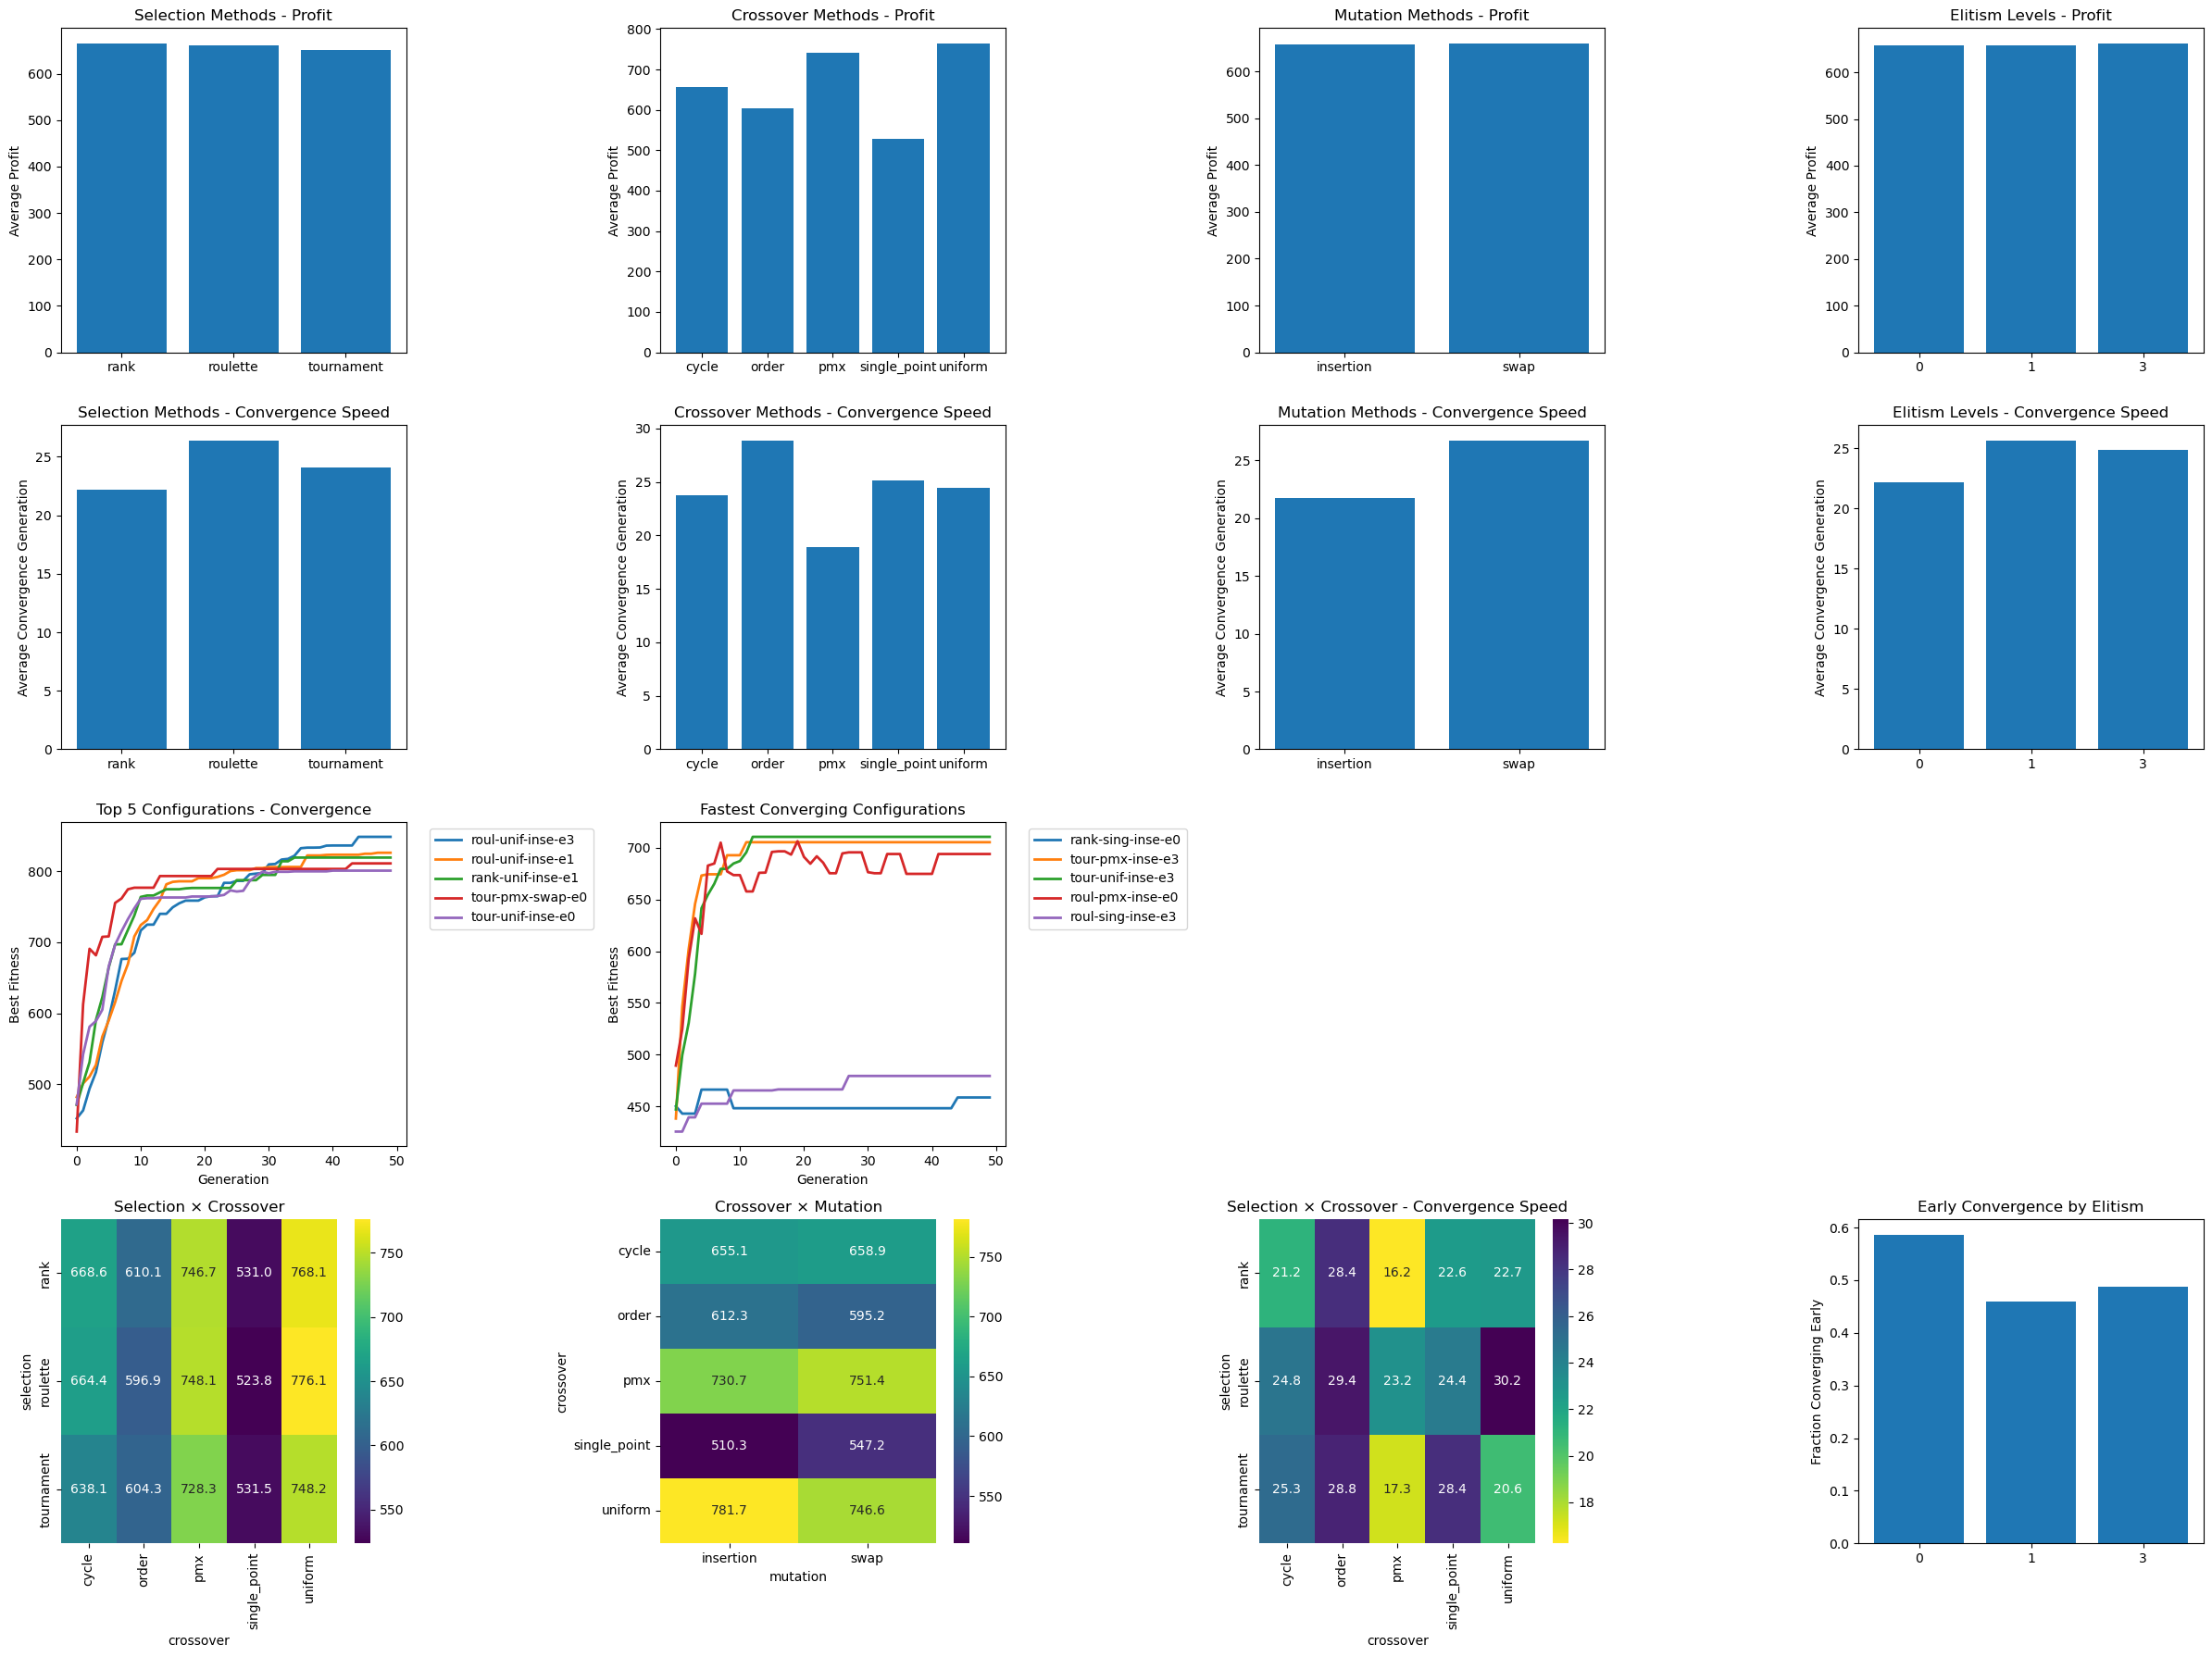


ENHANCED RECOMMENDATIONS
Best overall configuration: roul-unif-inse-e3
  Average profit: 848.4
  Convergence generation: 38.8
  Standard deviation: 65.75
  Average time: 0.034s

Fastest converging configuration: rank-sing-inse-e0
  Average profit: 478.6
  Convergence generation: 2.6
  Average time: 0.101s


In [53]:
print("\n" + "="*60)
print("FULL FACTORIAL DESIGN RESULTS WITH CONVERGENCE ANALYSIS")
print("="*60)

# Top performers for the dataset
print("\nTOP 10 CONFIGURATIONS:")
top_configs = results_df.sort_values('avg_profit', ascending=False)
print(top_configs[['config', 'avg_profit', 'std_profit', 'convergence_gen', 'avg_time']].head(10).to_string(index=False))

# Convergence 
print("\n" + "="*40)
print("CONVERGENCE ANALYSIS")
print("="*40)

print("\nFastest Converging Configurations:")
fastest_converging = results_df.sort_values('convergence_gen').head(5)
print(fastest_converging[['config', 'avg_profit', 'convergence_gen', 'early_convergence']].to_string(index=False))

print("\nBest Improvement Ratios:")
best_improvement = results_df.sort_values('final_improvement', ascending=False).head(5)
print(best_improvement[['config', 'avg_profit', 'final_improvement', 'convergence_gen']].to_string(index=False))

# Main effects 
print("\n" + "="*40)
print("MAIN EFFECTS ANALYSIS")
print("="*40)

print("\nSelection Methods (average across all combinations):")
selection_perf = results_df.groupby('selection').agg({
    'avg_profit': ['mean', 'std'],
    'convergence_gen': 'mean',
    'avg_time': 'mean'
}).round(2)
print(selection_perf)

print("\nCrossover Methods (average across all combinations):")
crossover_perf = results_df.groupby('crossover').agg({
    'avg_profit': ['mean', 'std'],
    'convergence_gen': 'mean',
    'avg_time': 'mean'
}).round(2)
print(crossover_perf)

print("\nMutation Methods (average across all combinations):")
mutation_perf = results_df.groupby('mutation').agg({
    'avg_profit': ['mean', 'std'],
    'convergence_gen': 'mean',
    'avg_time': 'mean'
}).round(2)
print(mutation_perf)

print("\nElitism Impact (average across all combinations):")
elitism_perf = results_df.groupby('elitism').agg({
    'avg_profit': ['mean', 'std'],
    'convergence_gen': 'mean',
    'avg_time': 'mean'
}).round(2)
print(elitism_perf)

fig = plt.figure(figsize=(24, 18))

# 1. Main effects plots 
plt.subplot(4, 4, 1)
selection_means = results_df.groupby('selection')['avg_profit'].mean()
plt.bar(selection_means.index, selection_means.values)
plt.title('Selection Methods - Profit')
plt.ylabel('Average Profit')

plt.subplot(4, 4, 2)
crossover_means = results_df.groupby('crossover')['avg_profit'].mean()
plt.bar(crossover_means.index, crossover_means.values)
plt.title('Crossover Methods - Profit')
plt.ylabel('Average Profit')

plt.subplot(4, 4, 3)
mutation_means = results_df.groupby('mutation')['avg_profit'].mean()
plt.bar(mutation_means.index, mutation_means.values)
plt.title('Mutation Methods - Profit')
plt.ylabel('Average Profit')

plt.subplot(4, 4, 4)
elitism_means = results_df.groupby('elitism')['avg_profit'].mean()
plt.bar(elitism_means.index.astype(str), elitism_means.values)
plt.title('Elitism Levels - Profit')
plt.ylabel('Average Profit')

# 2. Convergence speed 
plt.subplot(4, 4, 5)
selection_conv = results_df.groupby('selection')['convergence_gen'].mean()
plt.bar(selection_conv.index, selection_conv.values)
plt.title('Selection Methods - Convergence Speed')
plt.ylabel('Average Convergence Generation')

plt.subplot(4, 4, 6)
crossover_conv = results_df.groupby('crossover')['convergence_gen'].mean()
plt.bar(crossover_conv.index, crossover_conv.values)
plt.title('Crossover Methods - Convergence Speed')
plt.ylabel('Average Convergence Generation')

plt.subplot(4, 4, 7)
mutation_conv = results_df.groupby('mutation')['convergence_gen'].mean()
plt.bar(mutation_conv.index, mutation_conv.values)
plt.title('Mutation Methods - Convergence Speed')
plt.ylabel('Average Convergence Generation')

plt.subplot(4, 4, 8)
elitism_conv = results_df.groupby('elitism')['convergence_gen'].mean()
plt.bar(elitism_conv.index.astype(str), elitism_conv.values)
plt.title('Elitism Levels - Convergence Speed')
plt.ylabel('Average Convergence Generation')

# 3. Top configurations convergence curves
plt.subplot(4, 4, 9)
top_5_configs = results_df.sort_values('avg_profit', ascending=False).head(5)
for _, config in top_5_configs.iterrows():
    config_key = f"{config['test_case']}-{config['config']}"
    if config_key in convergence_data:
        plt.plot(convergence_data[config_key], label=config['config'], linewidth=2)
plt.title('Top 5 Configurations - Convergence')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Fastest converging 
plt.subplot(4, 4, 10)
fastest_5_configs = results_df.sort_values('convergence_gen').head(5)
for _, config in fastest_5_configs.iterrows():
    config_key = f"{config['test_case']}-{config['config']}"
    if config_key in convergence_data:
        plt.plot(convergence_data[config_key], label=config['config'], linewidth=2)
plt.title('Fastest Converging Configurations')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


# 5. Interaction heatmaps
plt.subplot(4, 4, 13)
import seaborn as sns
interaction_sel_cross = results_df.groupby(['selection', 'crossover'])['avg_profit'].mean().unstack()
sns.heatmap(interaction_sel_cross, annot=True, fmt='.1f', cmap='viridis')
plt.title('Selection × Crossover')

plt.subplot(4, 4, 14)
interaction_cross_mut = results_df.groupby(['crossover', 'mutation'])['avg_profit'].mean().unstack()
sns.heatmap(interaction_cross_mut, annot=True, fmt='.1f', cmap='viridis')
plt.title('Crossover × Mutation')

# 6. Convergence speed 
plt.subplot(4, 4, 15)
convergence_heatmap = results_df.groupby(['selection', 'crossover'])['convergence_gen'].mean().unstack()
sns.heatmap(convergence_heatmap, annot=True, fmt='.1f', cmap='viridis_r') 
plt.title('Selection × Crossover - Convergence Speed')

# 7. Early convergence 
plt.subplot(4, 4, 16)
early_conv = results_df.groupby('elitism')['early_convergence'].mean()
plt.bar(early_conv.index.astype(str), early_conv.values)
plt.title('Early Convergence by Elitism')
plt.ylabel('Fraction Converging Early')

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("ENHANCED RECOMMENDATIONS")
print("="*50)

best_overall = results_df.loc[results_df['avg_profit'].idxmax()]
print(f"Best overall configuration: {best_overall['config']}")
print(f"  Average profit: {best_overall['avg_profit']:.1f}")
print(f"  Convergence generation: {best_overall['convergence_gen']:.1f}")
print(f"  Standard deviation: {best_overall['std_profit']:.2f}")
print(f"  Average time: {best_overall['avg_time']:.3f}s")

fastest_converging = results_df.loc[results_df['convergence_gen'].idxmin()]
print(f"\nFastest converging configuration: {fastest_converging['config']}")
print(f"  Average profit: {fastest_converging['avg_profit']:.1f}")
print(f"  Convergence generation: {fastest_converging['convergence_gen']:.1f}")
print(f"  Average time: {fastest_converging['avg_time']:.3f}s")

